# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# %matplotlib qt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import sys
sys.path.append("./")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow_tpls")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../workflow-test")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [4]:
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
# from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import fiona
import rasterio
import pickle

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [5]:
from IPython.display import HTML
from matplotlib import animation

In [6]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

In [29]:
watershed_name = "American"
meshRes = "250m-riverbed"
fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"./meshes/{watershed_name}_final_mesh-{meshRes}.exo"

fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_geol_map = "./figures/{}_geol_map.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)
fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

fname_mesh_pickle = f'./results/{watershed_name}_mesh.p'
# fname_soil_id = f'./results/{watershed_name}_soil_id-{meshRes}.txt'
# fname_geol_id = f'./results/{watershed_name}_geol_id-{meshRes}.txt'

fname_soil_id = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_soil_id-{meshRes}.txt'
fname_geol_id = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_geol_id-{meshRes}.txt'

fname_soil_prop = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_soil_prop-{meshRes}.csv"
fname_geol_prop = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_geol_prop-{meshRes}.csv"
fname_nlcd = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_nlcd-{meshRes}.csv"

In [8]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = '../data/hydrologic_units/yakima/yakima_EPSG4269.shp'
watershed_shapefile = '../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp'
# watershed_shapefile = '../data/hydrologic_units/yakima/UpperYakima_EPSG4269c.shp'

# river_shp = "../data/hydrologic_units/yakima/yakima_river_network.shp"

# fname_hru = "../data/hydrologic_units/Maumee/EC_HRU_reproj.shp"
# fname_soil = "../data/soil/yakima/ssurgo_yakima.shp"
fname_soil = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/US_soil/gnatsgo_wa_raster/WA_MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
# fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/Yakima_river_watershed/yakima_GLHYMPS/yakima_watershed_GLHYMPS_v2.shp"
fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"

# fname_soil_prop = "/Users/shua784/OneDrive - PNNL/github/yakima/data/material/soil_prop_WA.csv"
# fname_geol_prop = "/Users/shua784/OneDrive - PNNL/github/yakima/data/material/geol_prop_yakima.csv"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [1020]:
# with fiona.open(watershed_shapefile, 'r') as fid:
#     profile = fid.profile
#     shps = [s for (i,s) in fid.items()]

# shplys = [workflow.utils.shply(shp) for shp in shps]
# simp_shp = shplys[0].simplify(100)
# plt.plot(*simp_shp.exterior.xy)

# shplys[0].area
# simp_shp.area

In [9]:
# hint = '0410'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape


logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info("watershed CRS: {}".format(crs))

2021-03-12 14:47:12,215 - root - INFO: 
2021-03-12 14:47:12,216 - root - INFO: Meshing shape: ../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp
2021-03-12 14:47:12,217 - root - INFO: ==============================
2021-03-12 14:47:12,217 - root - INFO: 
2021-03-12 14:47:12,218 - root - INFO: Preprocessing Shapes
2021-03-12 14:47:12,218 - root - INFO: ------------------------------
2021-03-12 14:47:12,219 - root - INFO: loading file: "../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp"
2021-03-12 14:47:12,364 - root - INFO: watershed CRS: EPSG:2856


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [10]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
# use 10-m DEM instead
# sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2021-03-12 14:47:14,557 - root - INFO: Using sources:
2021-03-12 14:47:14,557 - root - INFO: --------------
2021-03-12 14:47:14,558 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-03-12 14:47:14,558 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-03-12 14:47:14,559 - root - INFO: DEM: National Elevation Dataset (NED)
2021-03-12 14:47:14,559 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-03-12 14:47:14,560 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-03-12 14:47:14,560 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-03-12 14:47:14,561 - root - INFO: soil thickness: None
2021-03-12 14:47:14,561 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

## import river shapes

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint = '1703', shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

In [12]:
# sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']

In [11]:
huc = "1703000201" # provide the HUC8 for NHD or HUC4 for NHDPlus that includes that watershed
simplify = 50 # unit in crs, this may be useful to smooth both river segments and huc boundary

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, 
                                         cut_intersections=True,
                                        ignore_small_rivers=2, prune_by_area_fraction=0.01
                                        )

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2021-03-12 14:47:21,804 - root - INFO: 
2021-03-12 14:47:21,805 - root - INFO: Preprocessing Hydrography
2021-03-12 14:47:21,805 - root - INFO: ------------------------------
2021-03-12 14:47:21,806 - root - INFO: Loading streams in HUC 1703000201
2021-03-12 14:47:21,806 - root - INFO:          and/or bounds (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2021-03-12 14:47:21,808 - root - INFO: Using Hydrography file "/Users/shua784/github/workflow-test/examples/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2021-03-12 14:47:22,809 - root - INFO:   found 1288 reaches
2021-03-12 15:03:55,985 - root - INFO: 
2021-03-12 15:03:55,986 - root - INFO: Simplifying and pruning
2021-03-12 15:03:55,986 - root - INFO: ------------------------------
2021-03-12 15:03:55,987 - root - INFO: Filtering rivers outside of the HUC space
2021-03-12 15:03:55,988 - root - INFO:   ...filtering
2021-03-12 15:04:00,360 - root - INFO:   filtered from 1288 to 587 reaches.
20

### plot watershed bnd and river networks

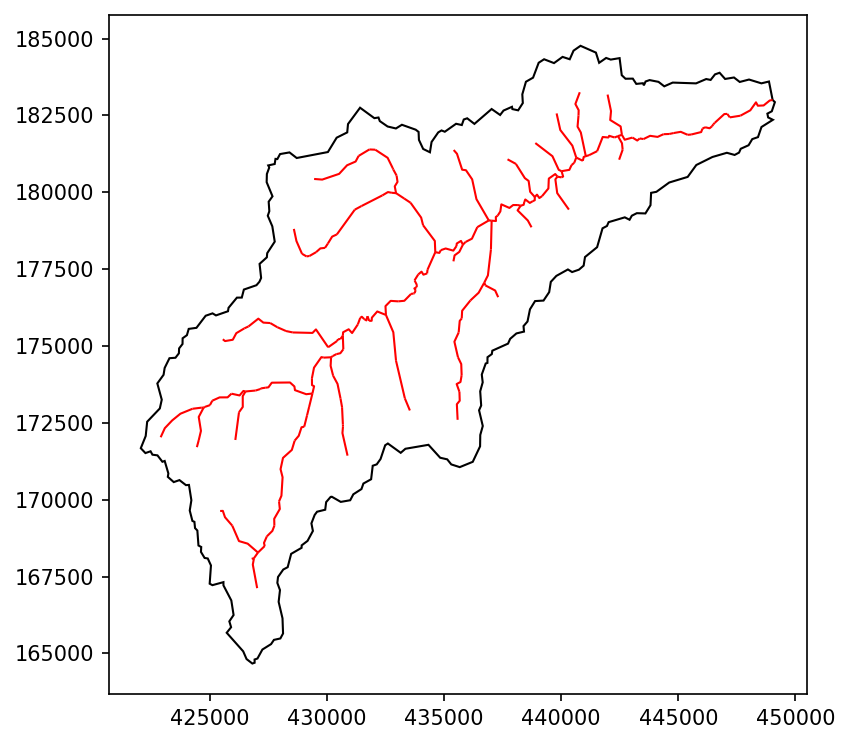

In [12]:
# plot what we have so far -- an image of the HUC and its stream network
fig,ax = plt.subplots(1,1, figsize=(6,6))
# ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

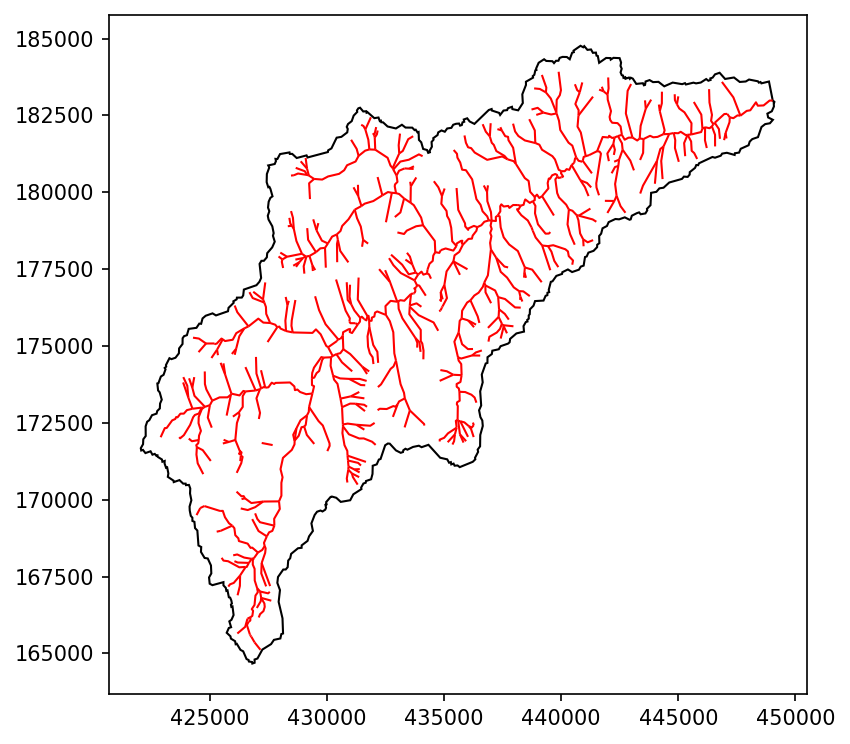

2021-03-12 15:09:01,235 - root - INFO: 
2021-03-12 15:09:01,235 - root - INFO: Meshing
2021-03-12 15:09:01,236 - root - INFO: ------------------------------
2021-03-12 15:09:01,238 - root - INFO: Triangulating...
2021-03-12 15:09:01,239 - root - INFO:    257 points and 257 facets
2021-03-12 15:09:01,240 - root - INFO:  checking graph consistency
2021-03-12 15:09:01,240 - root - INFO:  tolerance is set to 1
2021-03-12 15:09:01,242 - root - INFO:  building graph data structures
2021-03-12 15:09:01,244 - root - INFO:  triangle.build...
2021-03-12 15:09:01,245 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2021-03-12 15:09:03,736 - root - INFO:   ...built: 4132 mesh points and 7916 triangles
2021-03-12 15:09:03,736 - root - INFO: Plotting triangulation diagnostics
2021-03-12 15:09:04,638 - root - INFO:   min area = 2436.565872192383
2021-03-12 15:09:04,640 - root - INFO:   max are

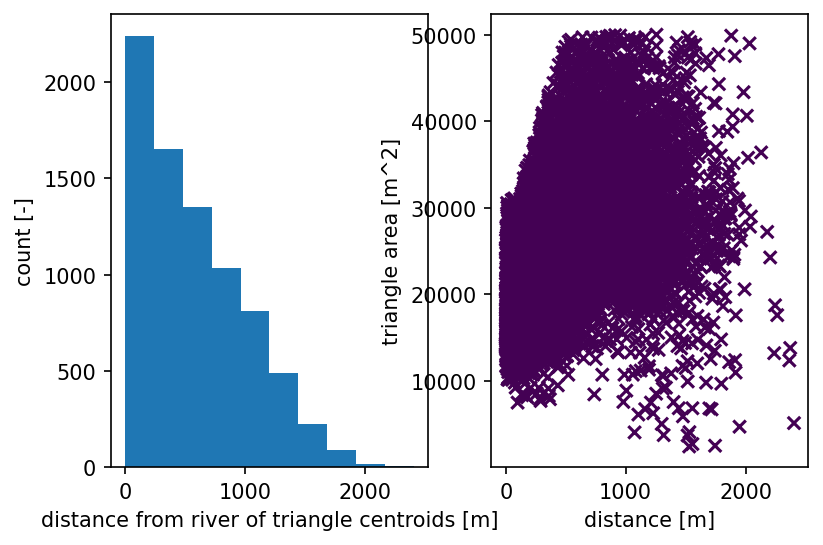

In [13]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.

# d0 = 10; d1 = 100
d0 = 100; d1 = 500

# A0 = 50; A1 = 50000 # [40, 310]m
# A0 = 1000; A1 = 50000 # [40, 310]m
# A0 = 1250; A1 = 50000 # [50, 310]m
# A0 = 5000; A1 = 50000 # [~100, 310]m
# A0 = 10000; A1 = 50000 # [~140, 310]m
# A0 = 20000; A1 = 50000 # [~200, 310]m
A0 = 31250; A1 = 50000 # [250, 310]m
# A0 = 50000; A1 = 50000 # [~310, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers,                                                 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

### find river region

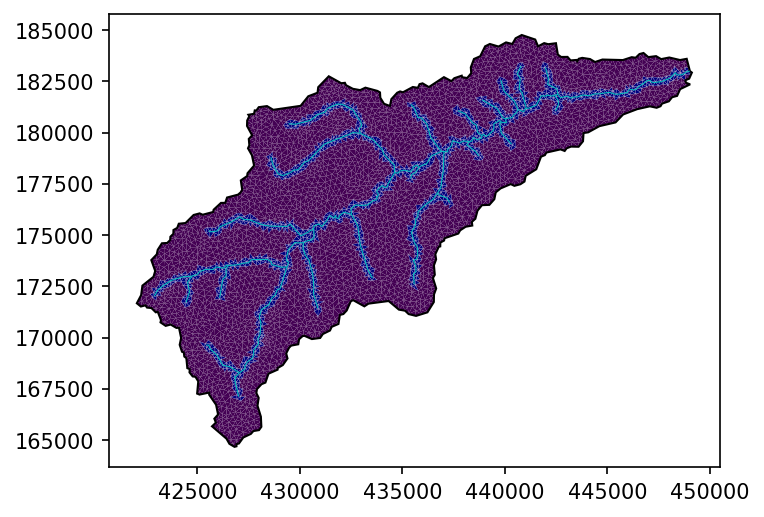

In [63]:
river_idx = distances < 200
river_tris = mesh_tris[river_idx]

colors = np.array([1]*len(river_tris))

fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_aspect('equal')
ax.tripcolor(mesh_points2[:,0], mesh_points2[:,1], mesh_tris, facecolors= np.array([0]*len(mesh_tris)), 
                   cmap = None, edgecolors = 'w', linewidth=0.01)
tpc = ax.tripcolor(mesh_points2[:,0], mesh_points2[:,1], river_tris, facecolors= colors, 
                   cmap = 'jet', edgecolors = 'w', linewidth=0.1)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='c', linewidth=0.5)

## Download DEM

2021-03-12 15:12:59,730 - root - INFO: 
2021-03-12 15:12:59,731 - root - INFO: Preprocessing Raster
2021-03-12 15:12:59,731 - root - INFO: ------------------------------
2021-03-12 15:12:59,740 - root - INFO: collecting raster
2021-03-12 15:13:00,038 - root - INFO: Collecting DEMs to tile bounds: [-121.57201823007883, 46.77386347353251, -121.1192600211822, 47.02996048597082]
2021-03-12 15:13:00,039 - root - INFO:   Need:
2021-03-12 15:13:00,040 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n47_w122.img
2021-03-12 15:13:00,040 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n48_w122.img
2021-03-12 15:13:00,041 - root - INFO: source files already exist!
2021-03-12 15:13:00,100 - root - INFO: Got raster of shape: (922, 1630)
2021-03-12 15:13:00,101 - root - INFO: resamping raster using bilinear method...
2021-03-12 15:13:00,843 - root - INFO: Raster bounds: (418133.3637338164, 189136.78189925852, 452933.36373381

<Figure size 900x600 with 0 Axes>

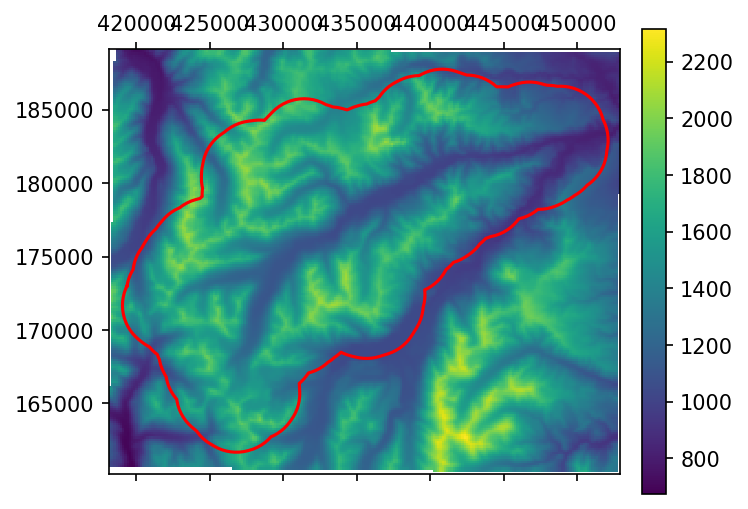

In [20]:
# get a raster for the elevation map, based on NED
# dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs, 
                                                buffer = 3000, 
                                                resampling_res= 150,
                                                plot_dem = True, 
                                                 )

**smooth dem**

In [18]:
from scipy.ndimage import gaussian_filter

2021-03-12 15:13:06,209 - root - INFO: smoothing using Gaussian filter with sigma = 3...
2021-03-12 15:13:06,211 - root - INFO: 
2021-03-12 15:13:06,212 - root - INFO: Elevating Triangulation to DEM
2021-03-12 15:13:06,212 - root - INFO: ------------------------------
2021-03-12 15:13:06,278 - root - INFO: raw minmax: 674.5357666015625, 2315.681396484375
2021-03-12 15:13:06,280 - root - INFO: smoothed minmax: 780.6786499023438, 2095.893310546875


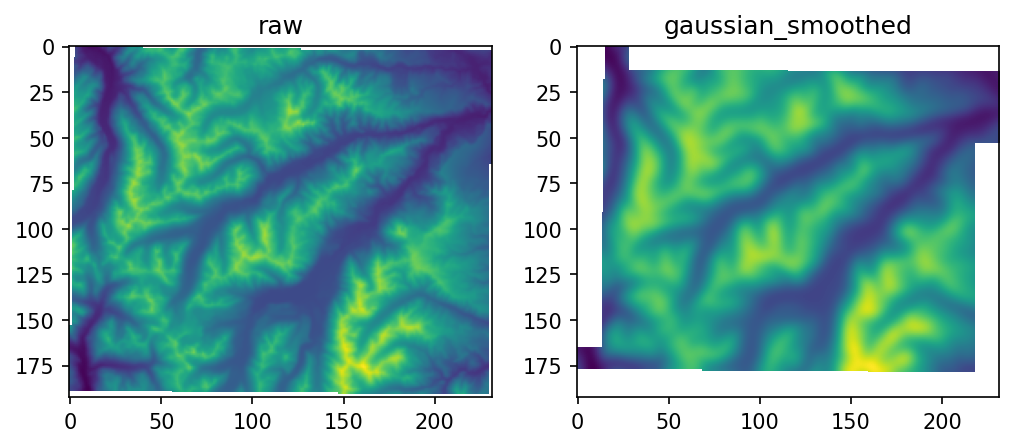

In [21]:
smooth = True
if smooth:
    sigma = 3
    logging.info(f"smoothing using Gaussian filter with sigma = {sigma}...")
    dem_s = gaussian_filter(dem, sigma = sigma, mode='nearest')
    mesh_points3 = workflow.elevate(mesh_points2, crs, dem_s, dem_profile)

    fig, axes = plt.subplots(1,2, figsize=(8,4))
    ax = axes[0]
    ax.imshow(dem)
    ax.set_title('raw')
    logging.info(f'raw minmax: {np.nanmin(dem)}, {np.nanmax(dem)}')
    ax = axes[1]
    ax.imshow(dem_s)
    ax.set_title('gaussian_smoothed')
    logging.info(f'smoothed minmax: {np.nanmin(dem_s)}, {np.nanmax(dem_s)}')
else:
    # elevate the triangle nodes to the dem
    mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)
    
if np.isnan(mesh_points3).any():
    raise ValueError("nan value is found in the mesh points. try larger buffer zone!")

### Map mesh to DEM

In [91]:
# # resample the raster to the triangles
# DEM_mesh = workflow.values_from_raster(m2.centroids(), crs, dem, dem_profile)

In [21]:
# # elevate the triangle nodes to the dem
# mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2021-02-09 14:51:32,360 - root - INFO: 
2021-02-09 14:51:32,360 - root - INFO: Elevating Triangulation to DEM
2021-02-09 14:51:32,361 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

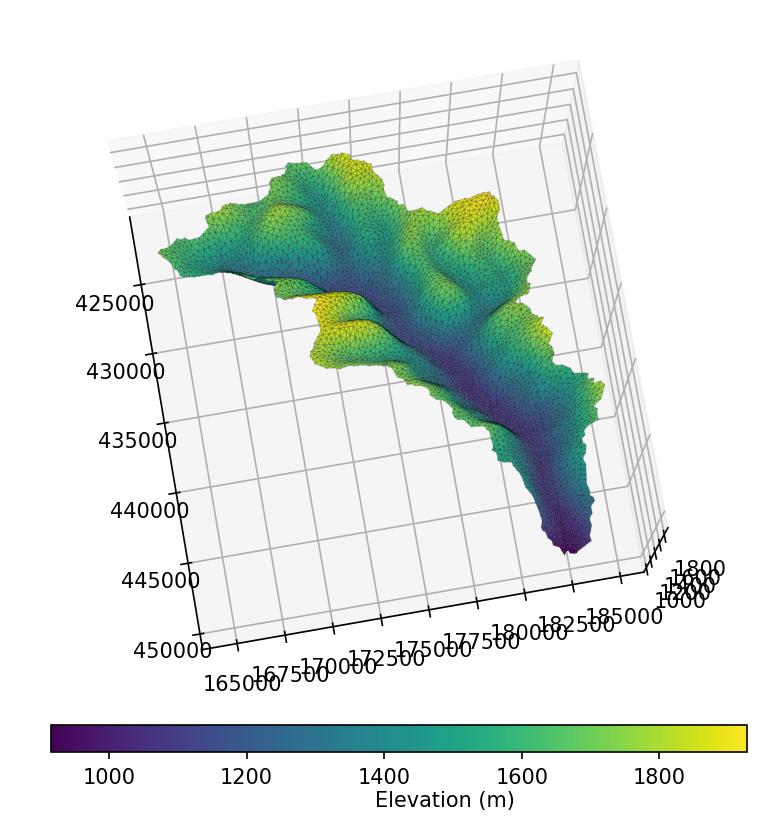

In [22]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

# t = cax.set_title('elevation [m]')
plt.text(0.5, -0.1, 'Elevation (m)', transform=ax.transAxes)

ax.view_init(80,-10)
# ax.set_xticklabels(list())
# ax.set_yticklabels(list())

# fig.savefig(fig_mesh3D, dpi = 300, transparent= True)

In [23]:
# visualize in animation
def animate(frame):
    ax.view_init(80, frame/4)
    plt.pause(.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

2021-01-06 16:44:08,202 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-06 16:44:08,204 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x900 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/b_/kpbcrn3s4_1770_6k278969jd__sdl/T/tmp9_yfdonf/temp.m4v


(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


Text(0.5, 1.0, 'Elevation [m]')

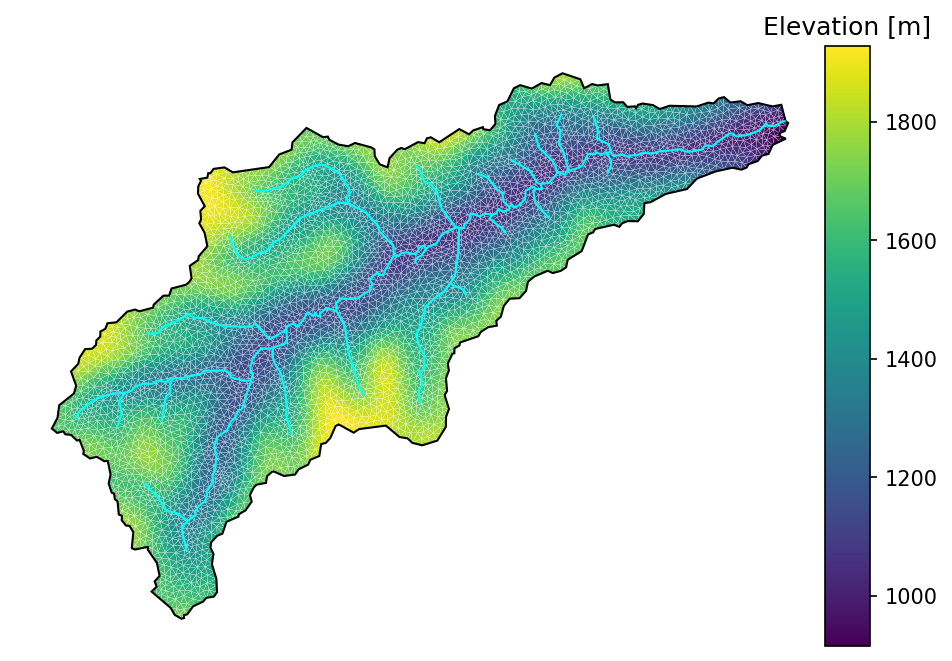

In [23]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

bxlim = (591000., 600000.)
bylim = (94000., 103000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')

# fig.tight_layout()
# fig.savefig(fig_mesh, dpi = 300, transparent = True)

(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


Text(0.5, 1.0, 'Elevation [m]')

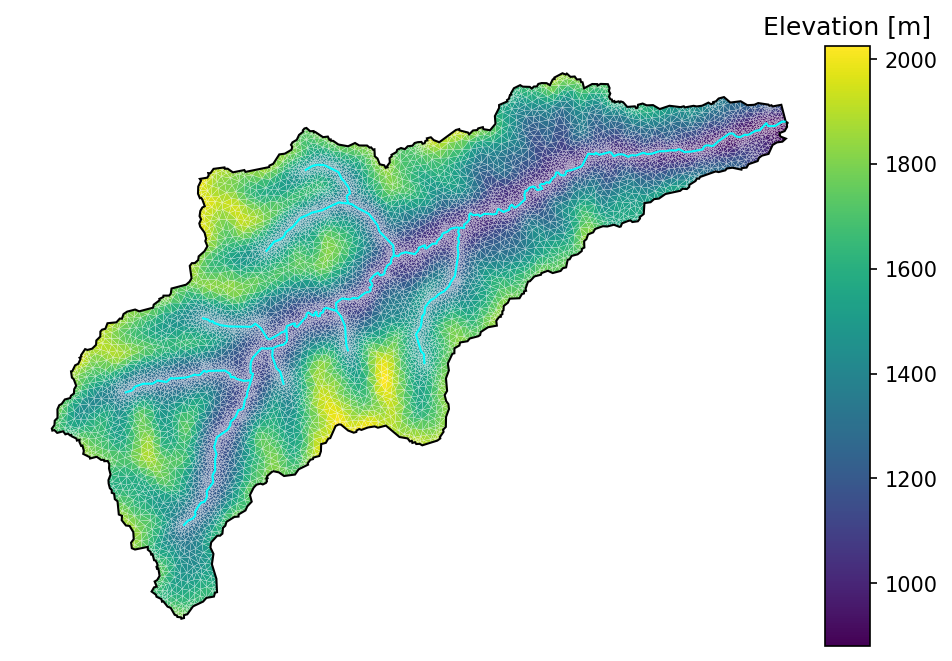

(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


Text(0.5, 1.0, 'Elevation [m]')

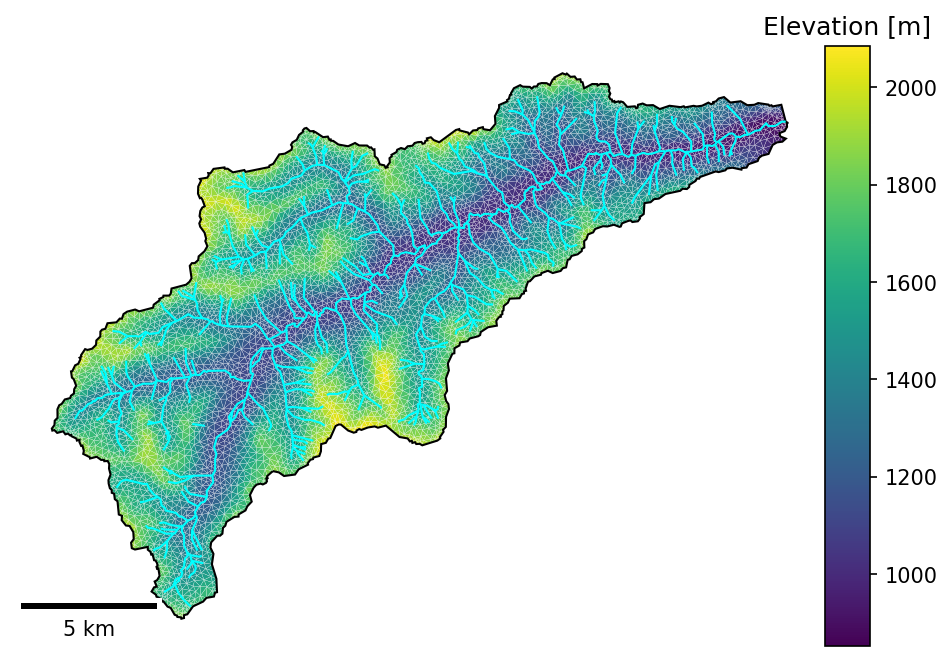

In [18]:
# with open(fname_mesh_pickle, 'wb') as f:
#     pickle.dump((mesh_points3, mesh_points2, mesh_tris), f, protocol=-1)

### construct 2d mesh 

In [112]:
# with open(fname_mesh_pickle, 'rb') as f:
#     mesh_points3, mesh_points2, mesh_tris = pickle.load(f)

In [24]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

2021-03-12 15:14:25,316 - root - INFO: max diff = 35.12978351612492 


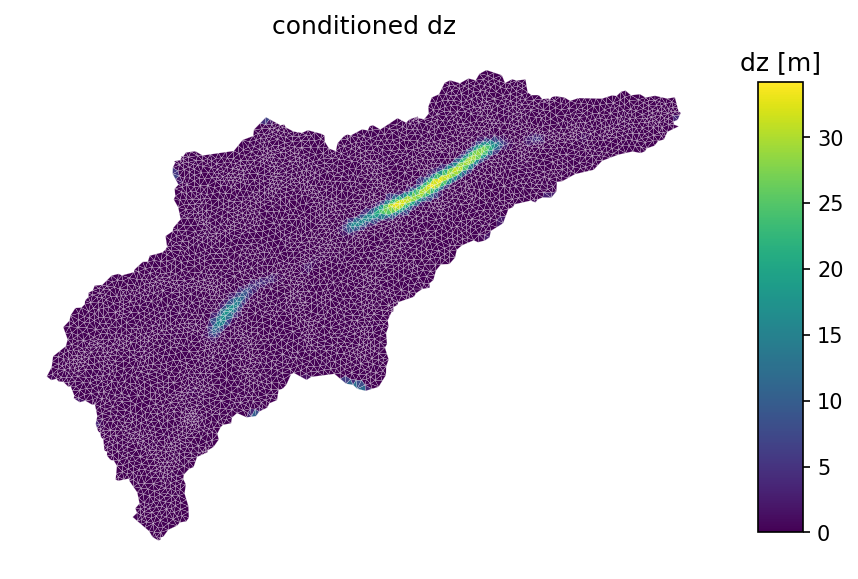

In [25]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()} ")
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
cbax = fig.add_axes([.95,0.25,0.05,0.5])

mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='white', 
                            linewidth=0.1, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')
plt.show()

### Export surface mesh

In [115]:
# m2.write_VTK(fname_surface_mesh)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [119]:
# m2 = workflow.mesh.Mesh2D.read_VTK(fname_surface_mesh)

In [26]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs,
                                                     )

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-03-12 15:14:34,363 - root - INFO: 
2021-03-12 15:14:34,363 - root - INFO: Preprocessing Raster
2021-03-12 15:14:34,363 - root - INFO: ------------------------------
2021-03-12 15:14:34,364 - root - INFO: collecting raster
2021-03-12 15:14:34,376 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-03-12 15:14:34,535 - root - INFO: Got raster of shape: (542, 973)
2021-03-12 15:14:34,535 - root - INFO: Raster bounds: (-193

In [27]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

In [ ]:
if len(nlcd_indices) != len(nlcd_labels):
    nlcd_labels = [i for i in nlcd_labels if i]
    assert(len(nlcd_indices) == len(nlcd_labels))

area_list = [areas[lc==i].sum() for i in nlcd_indices]
area_coverage = np.array(area_list) / areas.sum() * 100

nlcd_df = pd.DataFrame([nlcd_indices, nlcd_labels, area_list]).T
nlcd_df.columns = ['id', 'name', 'area']
nlcd_df.set_index('id', inplace = True)

nlcd_df['coverage [%]'] = area_coverage

nlcd_df.to_csv(fname_nlcd)

(420690.9079, 450480.0101, 163665.86095, 185768.07405000002)

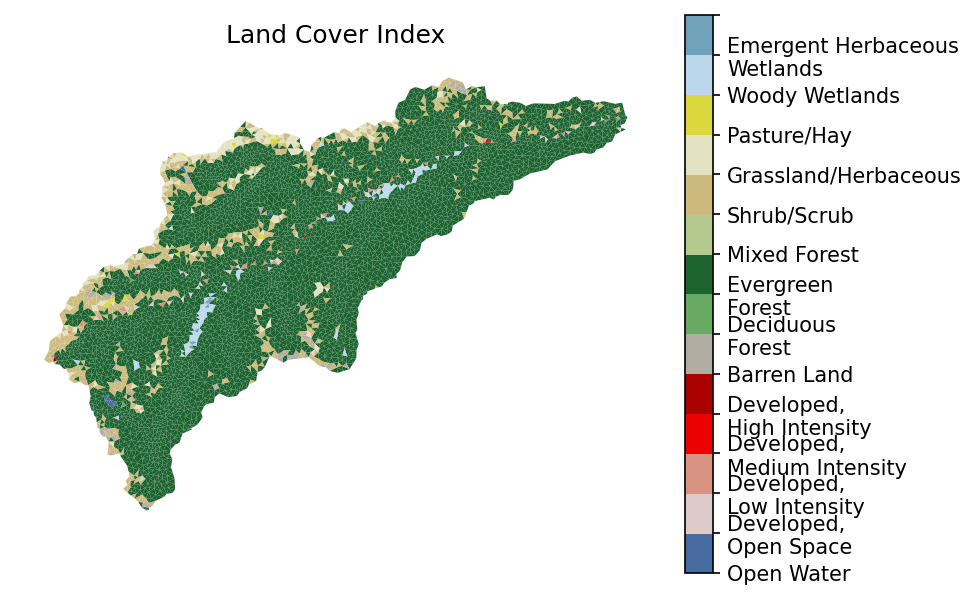

In [31]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
# fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

In [ ]:
# soil_profile, soil_raster = workflow.get_raster_on_shape(fname_soil, watershed.exterior(), crs)

# # resample the raster to the triangles
# soil_color = workflow.values_from_raster(m2.centroids(), crs, soil_raster, soil_profile)

In [32]:
# download the NRCS soils data as shapes and project it onto the mesh
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
_, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], target_bounds, crs, 
                                                        properties=True
                                                       )
# _, soil_survey = workflow.get_shapes(sources['soil structure'], target_bounds, crs)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-03-12 15:16:51,083 - root - INFO: target bounds: (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2021-03-12 15:16:51,083 - root - INFO: 
2021-03-12 15:16:51,084 - root - INFO: Preprocessing Shapes
2021-03-12 15:16:51,084 - root - INFO: ------------------------------
2021-03-12 15:16:51,389 - root - INFO: Attempting to download source for target '/Users/shua784/github/workflow-test/examples/data/soil_structure/SSURGO/SSURGO_-121.5250_46.8102_-121.1666_46.9938.gml'
../../workflow-test/workflow/sources/manager_nrcs.py:272: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shapes = [_flip(s) for s in fid]
2021-03-12 15:16:51,525 - root - INFO:   Found 879 shapes.
2021-03-12 15:16:51,526 - root - INFO:   and crs: EPSG:4326
2021-03-12 15:16:51,577 - root - INFO: found 137 unique MUKEYs.
2021-03-12 15:16:59,590 - root - INFO: Running Rosetta for van Genutchen parameters
2021-03-12

In [33]:
area_list = [areas[soil_color==i].sum() for i in np.unique(soil_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

soil_survey_props.set_index('mukey', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
soil_id_df = pd.DataFrame(np.array(np.unique(soil_color, return_counts=True)).T, columns = ['mukey', 'count'])
soil_id_df.set_index('mukey', inplace = True)
soil_id_df['area'] = area_list
soil_id_df['coverage [%]'] = area_coverage

soil_prop_df = soil_survey_props.merge(soil_id_df, how = 'inner', left_on='mukey', right_on = 'mukey', sort = True)
soil_prop_df.to_csv(fname_soil_prop)

In [ ]:
# print(soil_survey_props)

### plot soil map

Text(0.5, 1.0, 'soil type index')

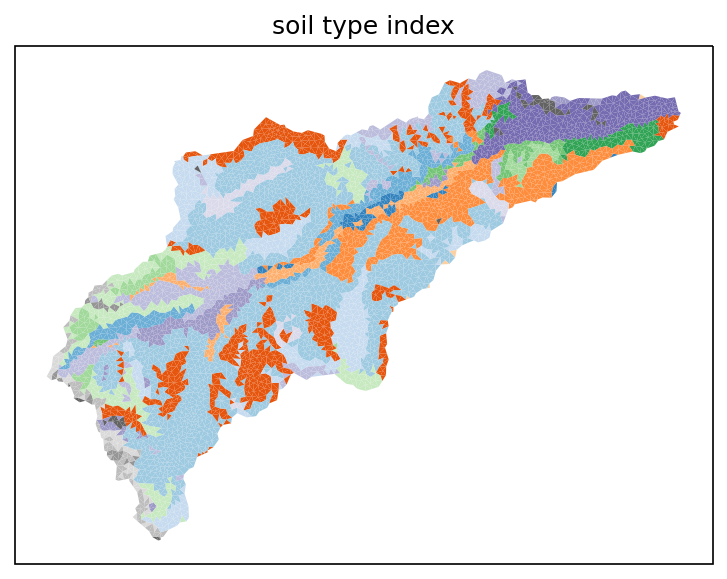

In [34]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap = 'tab20c')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )
ax.set_title('soil type index')

# fig.savefig('watershed_soils')

In [36]:
# soil_survey_props.to_csv(fname_soil_prop, index = False)

## map geology

1. Manually download global geology map (GLHYMPS v2.0) from [here](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/TTJNIU)
2. Extract the shapefile 
3. (optional) clip the global map to watershed shape. This will increase the processing speed.

In [35]:
target_bounds = watershed.exterior().bounds

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], target_bounds, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)

2021-03-12 15:19:18,696 - root - INFO: 
2021-03-12 15:19:18,696 - root - INFO: Preprocessing Shapes
2021-03-12 15:19:18,697 - root - INFO: ------------------------------
2021-03-12 15:19:18,841 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
../../workflow-test/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-03-12 15:19:39,961 - root - INFO: shape union bounds: (386911.3214970341, 112379.03856700905, 558658.3888897153, 233173.46442265552)
2021-03-12 15:19:39,962 - root - INFO: Coloring shapes onto raster:
2021-03-12 15:19:39,962 - root - INFO:   target_bounds = (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2021-03-12 15:19:39,962 - root - INFO:   out_bounds = [422040.0, 164668.0, 449140.0, 184768.0]
2021-03-12 15:19:39,963 - root - INFO:   pixel_size = 10
2021-03-12 15:19:39,963 

In [36]:
area_list = [areas[geo_color==i].sum() for i in np.unique(geo_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

geo_survey_props.set_index('id', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
geo_id_df = pd.DataFrame(np.array(np.unique(geo_color, return_counts=True)).T, columns = ['id', 'count'])
geo_id_df.set_index('id', inplace = True)
geo_id_df['area'] = area_list
geo_id_df['coverage [%]'] = area_coverage

geo_prop_df = geo_survey_props.merge(geo_id_df, how = 'inner', left_on='id', right_on = 'id', sort = True)
geo_prop_df.to_csv(fname_geol_prop)

In [ ]:
# _, geology = workflow.get_shapes(fname_geology, index_or_bounds=target_bounds, crs=crs)

# -- resample the raster to the triangles
# geol_color = workflow.values_from_raster(m2.centroids(), crs, 
#                                          geol_color_raster, geol_color_profile)

# unique_geol_id = np.unique(geo_color)
# logging.info(f'unique geology ids: {np.array(np.unique(geo_color, return_counts=True)).T}')

# np.savetxt(fname_geol_id, np.array(np.unique(geo_color, return_counts=True)).T, 
#            delimiter=' ', fmt = '%.0d')

In [318]:
# geo_survey_props.set_index('id', inplace = True)
# sub_geo_props = geo_survey_props.loc[unique_geol_id, :]
# # sub_geo_props
# sub_geo_props.to_csv(fname_geol_prop)

**map geology id to meshes**

In [ ]:
# # target_bounds = watershed.exterior().bounds
# shape_union_bounds = shapely.ops.cascaded_union(geology).bounds

# # -- log the bounds targetted and found
# logging.info(f'target bounds: {target_bounds}')
# logging.info(f'shape union bounds: {shape_union_bounds}')
# if target_bounds[0] < shape_union_bounds[0] or target_bounds[1] < shape_union_bounds[1] or target_bounds[2] > shape_union_bounds[2] or target_bounds[3] > shape_union_bounds[3]:
#     raise RuntimeError('target watershed falls outside the shape union bound!')

# # -- determine the geology id for each polygon
# geol_ids = np.array([shp.properties['OBJECTID_1'] for shp in geology], np.int32)

# # convert shapefile to raster using geology ids
# geol_color_raster, geol_color_profile, img_bounds = \
#             workflow.color_raster_from_shapes(target_bounds, target_dx=10, shapes=geology,
#                                               shape_colors=geol_ids, shapes_crs = crs, nodata=-9999)

### plot geology map

(420690.9079, 450480.0101, 163665.86095, 185768.07405000002)

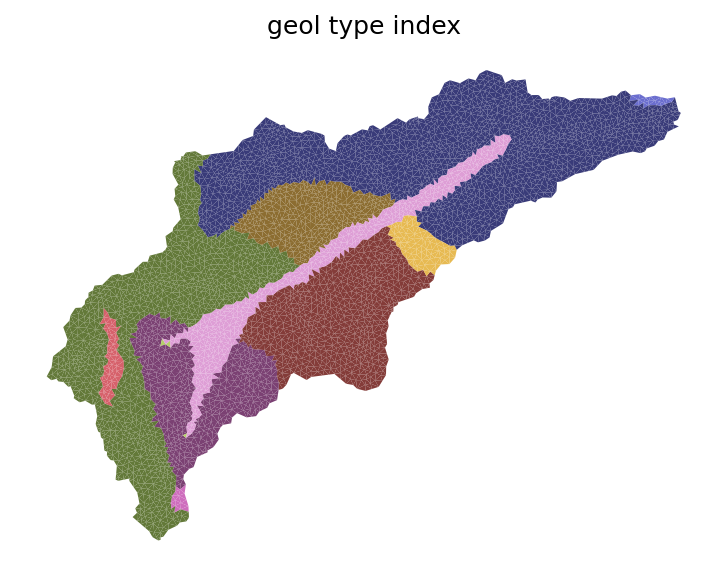

In [37]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20b')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, 
                        cmap=cmap, norm = norm
                        )
ax.set_title('geol type index')
ax.axis('off')
# ax.legend()

# fig.savefig(fig_geol_map, dpi = 300, transparent = True)

## get bedrock depth

Download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [38]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape(fname_DTB, watershed.exterior(), crs, nodata=-99999)

2021-03-12 15:20:04,779 - root - INFO: 
2021-03-12 15:20:04,779 - root - INFO: Preprocessing Raster
2021-03-12 15:20:04,780 - root - INFO: ------------------------------
2021-03-12 15:20:04,780 - root - INFO: loading file: "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
2021-03-12 15:20:04,781 - root - INFO: collecting raster
2021-03-12 15:20:04,966 - root - INFO: Got raster of shape: (89, 171)
2021-03-12 15:20:04,966 - root - INFO: Raster bounds: (-121.522926023, 46.99500646, -121.16667608, 46.809589822999996)


In [39]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)

In [40]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2021-03-12 15:20:06,971 - root - INFO: minimum depth-to-bedrock: 6.56 m
2021-03-12 15:20:06,972 - root - INFO: maximum depth-to-bedrock: 24.14 m


### plot depth to bedrock

In [41]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster, DTB_profile)

2021-03-12 15:20:09,521 - root - INFO: 
2021-03-12 15:20:09,522 - root - INFO: Elevating Triangulation to DEM
2021-03-12 15:20:09,522 - root - INFO: ------------------------------


(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


Text(0.5, 1.0, 'DTB [m]')

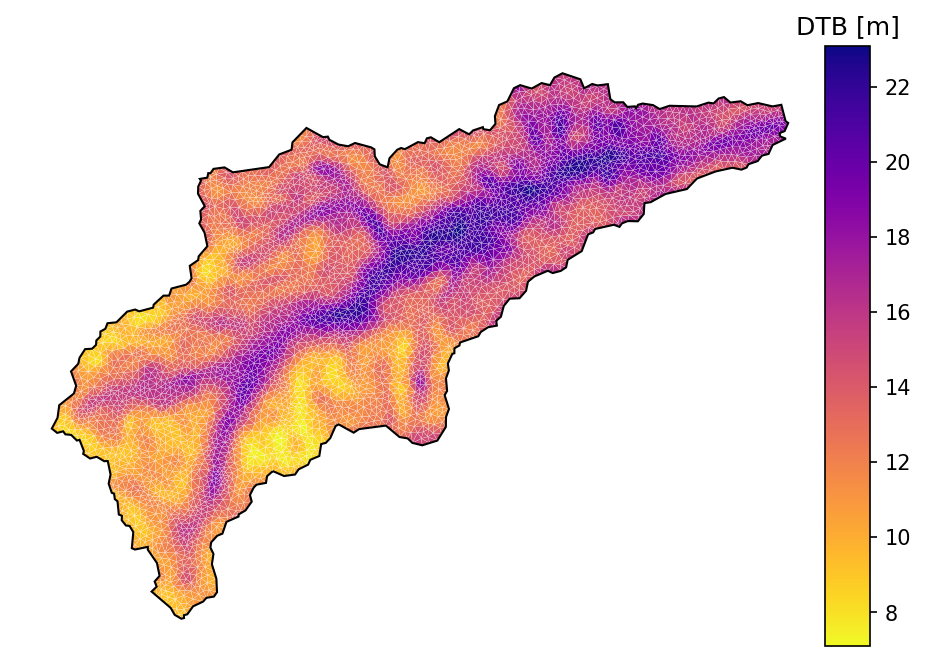

In [42]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

# bxlim = (591000., 600000.)
# bylim = (94000., 103000.)

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [m]')

# fig.tight_layout()
# fig.savefig(fig_DTB, dpi = 300, transparent = True)

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [43]:
total_tckness = np.ceil(DTB_mesh.max())
logging.info(f'total thickness: {total_tckness} m')

2021-03-12 15:20:15,677 - root - INFO: total thickness: 25.0 m


In [44]:
ele_per_layer = mesh_tris.shape[0]

In [46]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 6
dz = 0.05
layer_dz = 2 # total top thickness

tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
#     dz *= tele
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
#     ilayer_id = 900 + ncells + i + 1
#     layer_mat_ids.append(ilayer_id * np.ones_like(soil_color))
    layer_mat_ids.append(geo_color)
    z += dz    
    z_top.append(z)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-03-12 15:20:17,013 - root - INFO: Converged?: ratio = 1.7857749000436356, layer z (target = 2) = -5.985434370359144e-12
2021-03-12 15:20:17,014 - root - INFO: Got telescoping factor: 1.7857749000436356
2021-03-12 15:20:17,015 - root - INFO: Cell summary:
2021-03-12 15:20:17,015 - root - INFO: ------------------------------------------------------------
2021-03-12 15:20:17,016 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-03-12 15:20:17,016 - root - INFO: ------------------------------------------------------------
2021-03-12 15:20:17,017 - root - INFO:  00 	| 00 	| 75342 	|   0.050000 	|   0.000000
2021-03-12 15:20:17,017 - root - INFO:  01 	| 01 	| 75342 	|   0.090000 	|   0.050000
2021-03-12 15:20:17,018 - root - INFO:  02 	| 02 	| 75342 	|   0.160000 	|   0.140000
2021-03-12 15:20:17,018 - root - INFO:  03 	| 03 	| 75342 	|   0.290000 	|   0.300000
2021-03-12 15:20:17,019 - root - INFO:  04 	| 04 	| 75342 	|   0.520000 	|   0.590000
2021-03-12 15:20:17,019 - root - INFO

In [51]:
logging.info(f"No of cells: {len(layer_data)*ele_per_layer}")

2021-03-12 15:23:07,814 - root - INFO: No of cells: 142488


### add bedrock material

In [72]:
bedrock_id = 999
riverbed_id = 100
unique_mat_ids = geo_prop_df.index.tolist() + soil_prop_df.index.tolist() + [bedrock_id] + [riverbed_id]

if len(unique_mat_ids) != len(set(unique_mat_ids)): 
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock/riverbed ids!')

In [52]:
# get depth below top cell face
z_top = np.asarray(z_top) # relative distance to surface
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2 # cell center distance for each layer

In [55]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
#     idem = DEM_mesh[icol]
    idtb = DTB_mesh[icol]
#     ielev = idem - z_center
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = bedrock_id

### add riverbed material

In [79]:
alluvium_tck = 0.5 # m
layer_idx = sum(z_center < alluvium_tck) # find the top layers with a total thickness < 0.5 m
for ilayer in range(layer_idx):
    mat_ids[ilayer, river_idx] = riverbed_id

### extrusion

In [83]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

In [84]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [85]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [86]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/American_final_mesh-250m-riverbed.exo
Closing exodus file: ./meshes/American_final_mesh-250m-riverbed.exo
